# Chirp diagnostic
(see paper "Real-time chirp diagnostic for ultrashort laser pulses" (MOSAIC))

In [1]:
# Make plot in GUI
%matplotlib qt

In [2]:
# Make plots inline
%matplotlib inline

In [3]:
# Make inline plots vector graphics instead of raster graphics
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy import interpolate
from scipy import constants
from scipy import signal

Laser Wavelength in nm (Laser Frequency will be in THz therefore * $10^{-3})

In [5]:
wavelength_laser = 785
frequency_laser = constants.c / wavelength_laser * 10**(-3)

In [6]:
path = r"C:/Users/Julian/Dropbox/Masterarbeit/Data/Autocorrelator/TiSa_ACF_5ps_785nm.txt"

In [7]:
data = np.loadtxt(path)

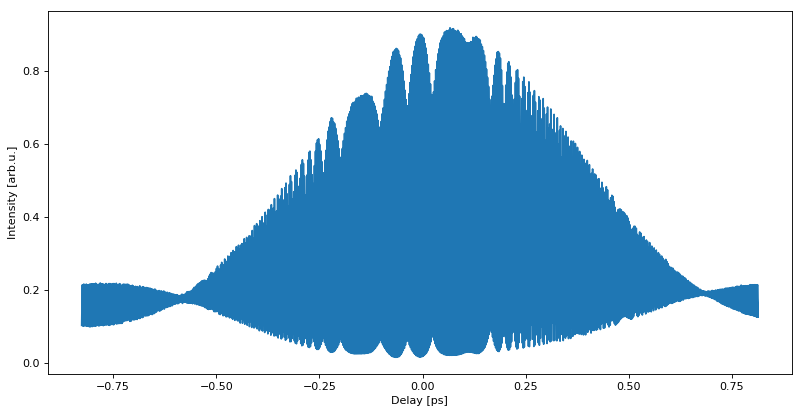

In [8]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 6), dpi=80)

plt.xlabel("Delay [ps]")
plt.ylabel("Intensity [arb.u.]")

plt.plot(data[:,0], data[:,1])
plt.show()

## Interpolation

(Alternative with non-uniform FFT see https://github.com/jakevdp/nfft)

In [9]:
func_linear_interp = interpolate.interp1d(data[:,0], data[:,1])

### Nyquist Theorem:
Use at least twice the highest frequency of the signal to sample it.

Highest Frequency is 2 * frequency of laser = 382 (THz) (THz is just noted, the frequencies therefore need to be multiplied by THz to get the physical value)

Minimum sample frequency is therefore 763.

We choose a sample frequency of 10000.

The time step is therefore $10^{-4}$

In [10]:
# Time step in ps
time_step =  1 * 10**(-4)

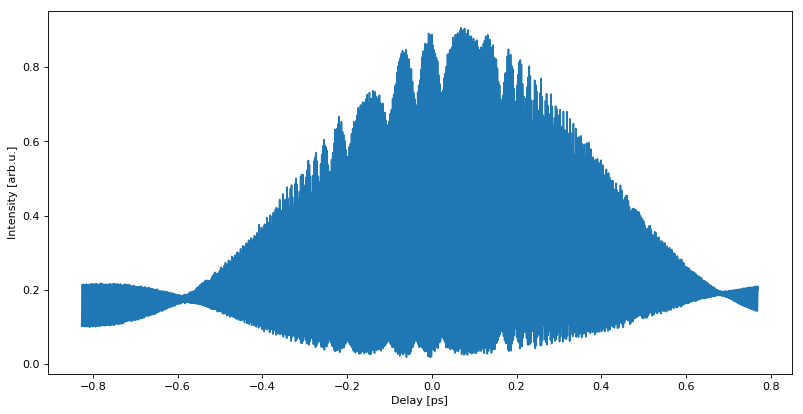

In [11]:
interpolation_time = np.arange(data[-1,0], data[0,0], time_step)
data_linear_interp = func_linear_interp(interpolation_time)

# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 6), dpi=80)

plt.xlabel("Delay [ps]")
plt.ylabel("Intensity [arb.u.]")

plt.plot(interpolation_time, data_linear_interp)
plt.show()


## FFT
Transform interpolated signal into frequency-space per FFT.

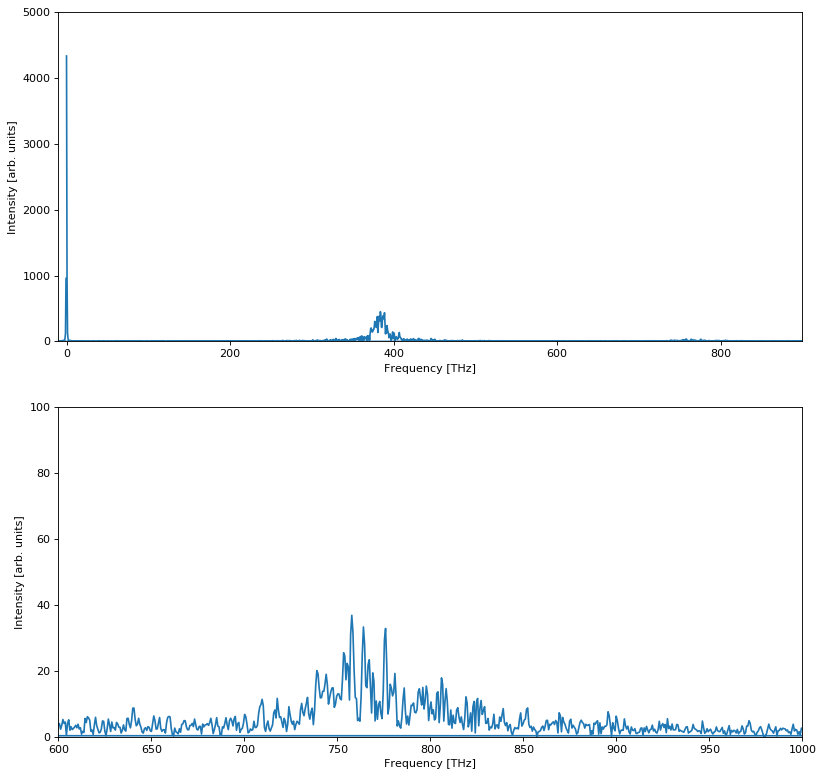

In [12]:
# The FFT of the signal
data_fft = fftpack.fft(data_linear_interp)

# And the power (sig_fft is of complex dtype)
data_power = np.abs(data_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(data_linear_interp.size, d=time_step)


# Plot the FFT power
plt.figure(figsize=(12, 12), dpi=80)

plt.subplot(211)
plt.xlabel('Frequency [THz]')
plt.ylabel('Intensity [arb. units]')
plt.xlim(-10, 900)
plt.ylim(0, 5000)
plt.plot(sample_freq, data_power)

plt.subplot(212)
plt.xlabel('Frequency [THz]')
plt.ylabel('Intensity [arb. units]')
plt.xlim(600, 1000)
plt.ylim(0, 100)
plt.plot(sample_freq, data_power)

plt.show()

## Alternative Implementation of the Filter
Citation from MOSAIC paper:
"The bandpass filter functions were taken as rectangular functions centered at $\omega$
and $2\omega$ having bandwidths of $\omega$.

Scipy Signal Filter Tutorial (https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)
How many taps? (https://dsp.stackexchange.com/a/31210)

In [13]:
# b, a = signal.butter(8, (0.038, 0.115), btype="bandstop")
b, a = signal.butter(8, (0.009, 0.9999), btype="bandstop")
filtered_data_3 = signal.filtfilt(b, a, data_linear_interp)

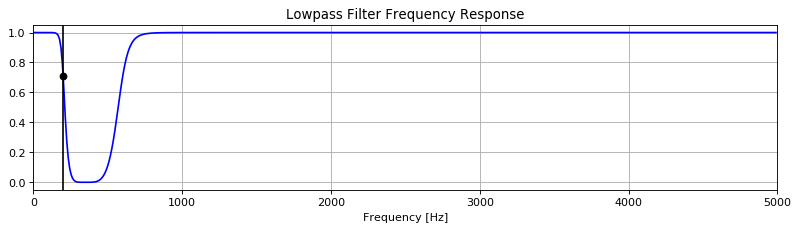

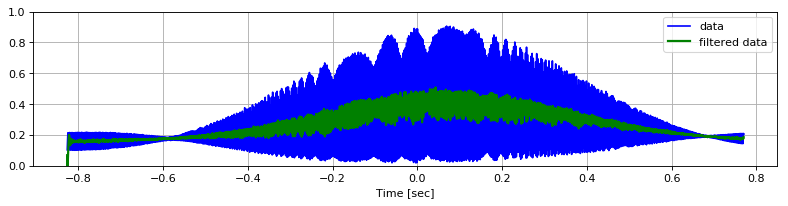

In [16]:
def butter_1(cutoff_1, cutoff_2, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff_1 = cutoff_1 / nyq
    normal_cutoff_2 = cutoff_2 / nyq
    b, a = signal.butter(order, (normal_cutoff_1, normal_cutoff_2) , btype='bandstop', analog=False)
    return b, a

def butter_1_filter(data, cutoff_1, cutoff_2, fs, order=5):
    b, a = butter_1(cutoff_1, cutoff_2, fs, order=5)
    y = signal.lfilter(b, a, data)
    return y


# Filter requirements.
order = 5
fs = 10000       # sample rate, Hz
cutoff_1 = 200  # desired cutoff frequency of the filter, Hz
cutoff_2 = 600  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_1(cutoff_1, cutoff_2, fs, order)

# Plot the frequency response.
w, h = signal.freqz(b, a)
plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff_1, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff_1, color='k')
plt.xlim(0, 0.5 * fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filter the data, and plot both the original and filtered signals.
y = butter_1_filter(data_linear_interp, cutoff_1, cutoff_2, fs, order)

plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(interpolation_time, data_linear_interp, 'b-', label='data')
plt.plot(interpolation_time, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.ylim(0, 1)
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

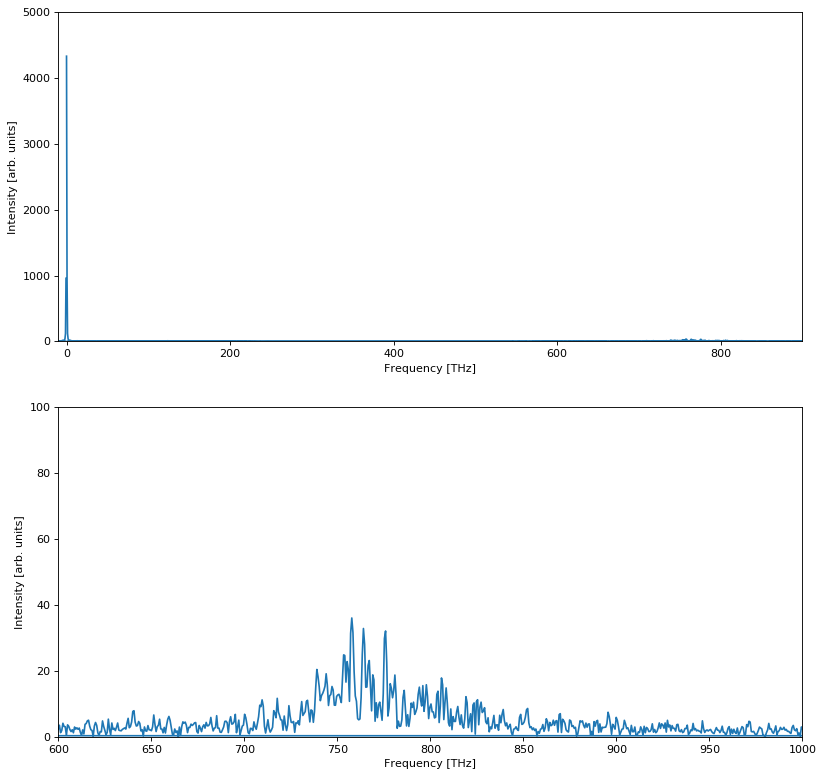

In [17]:
# The FFT of the signal
data_fft_2 = fftpack.fft(y)

# And the power (sig_fft is of complex dtype)
data_power_2 = np.abs(data_fft_2)

# Plot the FFT power
plt.figure(figsize=(12, 12), dpi=80)

plt.subplot(211)
plt.xlabel('Frequency [THz]')
plt.ylabel('Intensity [arb. units]')
plt.xlim(-10, 900)
plt.ylim(0, 5000)
plt.plot(sample_freq, data_power_2)

plt.subplot(212)
plt.xlabel('Frequency [THz]')
plt.ylabel('Intensity [arb. units]')
plt.xlim(600, 1000)
plt.ylim(0, 100)
plt.plot(sample_freq, data_power_2)

plt.show()